# wiki40b_jaコーパスをword2vecで学習する

## 必要なライブラリのインポート

In [17]:
# 必要なライブラリのインポート
from datasets import load_dataset
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from sudachipy import tokenizer, dictionary
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

## wiki40b_jaコーパスをロード

In [18]:
# wiki40b_jaコーパスをロード
print("データセットをロード中...")
ds = load_dataset("fujiki/wiki40b_ja")
print(f"train: {len(ds['train'])}件")
print(f"validation: {len(ds['validation'])}件")
print(f"test: {len(ds['test'])}件")

データセットをロード中...


2025-11-14 19:32:54,848 : INFO : HTTP Request: HEAD https://huggingface.co/datasets/fujiki/wiki40b_ja/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
2025-11-14 19:32:54,868 : INFO : HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/fujiki/wiki40b_ja/f4b757145a0964d08cb01f505c5d65a285333c5d/README.md "HTTP/1.1 200 OK"
2025-11-14 19:32:55,059 : INFO : HTTP Request: HEAD https://huggingface.co/datasets/fujiki/wiki40b_ja/resolve/f4b757145a0964d08cb01f505c5d65a285333c5d/wiki40b_ja.py "HTTP/1.1 404 Not Found"
2025-11-14 19:32:55,849 : INFO : HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/fujiki/wiki40b_ja/fujiki/wiki40b_ja.py "HTTP/1.1 404 Not Found"
2025-11-14 19:32:56,040 : INFO : HTTP Request: HEAD https://huggingface.co/datasets/fujiki/wiki40b_ja/resolve/f4b757145a0964d08cb01f505c5d65a285333c5d/.huggingface.yaml "HTTP/1.1 404 Not Found"
2025-11-14 19:32:56,283 : INFO : HTTP Request: GET https://datasets-server.huggingfac

train: 745392件
validation: 41576件
test: 41268件


## 前処理

In [19]:
# SudachiPyの初期化（粒度C、full辞書）
tokenizer_obj = dictionary.Dictionary(dict="full").create()
mode = tokenizer.Tokenizer.SplitMode.C  # 粒度C（最も粗い分割）


def tokenize_text(text):
    """テキストをSudachiPyで分かち書きして単語リストに変換"""
    if not text or not isinstance(text, str):
        return []

    # SudachiPyの制限（49149バイト）を超える場合は分割処理
    max_bytes = 40000  # 安全マージンを持たせる

    all_words = []

    # テキストをバイト数で分割
    current_pos = 0
    while current_pos < len(text):
        # 次のチャンクを取得（文字数で概算）
        chunk_size = max_bytes // 3  # UTF-8で1文字最大3バイトと仮定
        chunk = text[current_pos : current_pos + chunk_size]

        # バイト数を確認
        while len(chunk.encode("utf-8")) > max_bytes and len(chunk) > 0:
            chunk = chunk[:-100]  # 少しずつ削る

        if not chunk:
            break

        try:
            # SudachiPyでトークナイズ
            tokens = tokenizer_obj.tokenize(chunk, mode)
            # 正規化形を取得
            words = [
                m.normalized_form() for m in tokens if len(m.normalized_form()) > 1
            ]
            all_words.extend(words)
        except Exception as e:
            # エラーが出た場合はスキップ
            print(f"トークナイズエラー（スキップ）: {str(e)[:100]}")

        current_pos += len(chunk)

    return all_words


# テスト
sample_text = "これはテストです。日本語の形態素解析を行います。"
print("テスト:", tokenize_text(sample_text))

テスト: ['此れ', 'テスト', 'です', '日本語', '形態素解析', '行う', 'ます']


In [20]:
# コーパスをトークナイズ（文書ごとに単語リストに変換）
class TokenizedCorpus:
    """メモリ効率的にコーパスをトークナイズするイテレータ"""

    def __init__(self, dataset, max_docs=None):
        self.dataset = dataset
        self.max_docs = max_docs

    def __iter__(self):
        count = 0
        for item in self.dataset:
            if self.max_docs and count >= self.max_docs:
                break
            tokens = tokenize_text(item["text"])
            if tokens:  # 空でない場合のみ返す
                yield tokens
                count += 1


# 全データ（74万件）を使う場合（時間がかかる）
# tokenized_corpus = TokenizedCorpus(ds['train'])

# まずは一部でテスト（10万件）
tokenized_corpus = TokenizedCorpus(ds["train"], max_docs=100000)

print("トークナイズ済みコーパスを準備しました")

トークナイズ済みコーパスを準備しました


## Word2Vecモデルの学習

In [21]:
# ログ設定（学習状況を表示）
logging.basicConfig(
    format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO
)


class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.losses = []
        self.prev_loss = 0.0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        epoch_loss = loss - self.prev_loss
        self.prev_loss = loss
        self.losses.append(epoch_loss)
        print(f"Epoch {self.epoch + 1}: loss={epoch_loss:,.2f}")
        self.epoch += 1


loss_logger = LossLogger()


class TqdmTokenizedCorpus:
    def __init__(self, corpus, total=None):
        self.corpus = corpus
        self.total = total

    def __iter__(self):
        # tqdm オブジェクト自体を返さず、ここでループして yield する
        for sentence in tqdm(self.corpus, total=self.total, desc="Word2Vec training"):
            yield sentence

In [22]:
# Word2Vecモデルの学習

tqdm_corpus = TqdmTokenizedCorpus(
    tokenized_corpus, total=getattr(tokenized_corpus, "max_docs", None)
)

print("Word2Vecモデルを学習中...")

model = Word2Vec(
    sentences=tqdm_corpus,
    vector_size=300,  # ベクトルの次元数（100-300が一般的）
    window=5,  # 文脈ウィンドウサイズ
    min_count=5,  # 最低出現回数（5回未満の単語は無視）
    workers=4,  # 並列処理のワーカー数
    sg=0,  # 0=CBOW, 1=Skip-gram（CBOWの方が高速）
    epochs=5,  # エポック数
    seed=42,  # 再現性のためのシード
    compute_loss=True,  # 損失を計算して表示
    callbacks=[loss_logger],
)

print("\n学習完了!")
print(f"語彙数: {len(model.wv):,}語")
print(f"累積学習損失: {model.get_latest_training_loss():,.2f}")
print("各エポックの損失:", [f"{l:,.2f}" for l in loss_logger.losses])

2025-11-14 19:32:56,577 : INFO : collecting all words and their counts


Word2Vecモデルを学習中...


Word2Vec training: 100%|██████████| 100000/100000 [00:54<00:00, 1824.14it/s]
2025-11-14 19:33:51,398 : INFO : collected 661432 word types from a corpus of 24521368 raw words and 100000 sentences
2025-11-14 19:33:51,398 : INFO : Creating a fresh vocabulary
2025-11-14 19:33:51,573 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 189480 unique words (28.65% of original 661432, drops 471952)', 'datetime': '2025-11-14T19:33:51.573242', 'gensim': '4.4.0', 'python': '3.13.9 (main, Oct 28 2025, 12:02:14) [Clang 20.1.4 ]', 'platform': 'macOS-26.1-arm64-arm-64bit-Mach-O', 'event': 'prepare_vocab'}
2025-11-14 19:33:51,573 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 23756882 word corpus (96.88% of original 24521368, drops 764486)', 'datetime': '2025-11-14T19:33:51.573548', 'gensim': '4.4.0', 'python': '3.13.9 (main, Oct 28 2025, 12:02:14) [Clang 20.1.4 ]', 'platform': 'macOS-26.1-arm64-arm-64bit-Mach-O', 'event': 'prepare_vocab'}
2025-11-14 19:33

Epoch 1: loss=31,835,198.00


Word2Vec training: 100%|██████████| 100000/100000 [00:56<00:00, 1766.16it/s]
2025-11-14 19:35:47,533 : INFO : EPOCH 1: training on 24521368 raw words (20296132 effective words) took 56.6s, 358392 effective words/s


Epoch 2: loss=12,777,926.00


Word2Vec training:  54%|█████▍    | 54222/100000 [00:33<00:31, 1436.34it/s]2025-11-14 19:36:20,983 : INFO : EPOCH 2 - PROGRESS: at 54.24% examples, 324782 words/s, in_qsize 0, out_qsize 0
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Word2Vec training: 100%|██████████| 100000/100000 [01:01<00:00, 1617.90it/s]
2025-11-14 19:36:49,354 : INFO : EPOCH 2: training on 24521368 raw words (20296622 effective words) took 61.8s, 328311 effective words/s


Epoch 3: loss=10,754,652.00


Word2Vec training: 100%|██████████| 100000/100000 [01:03<00:00, 1579.71it/s]
2025-11-14 19:37:52,669 : INFO : EPOCH 3: training on 24521368 raw words (20296741 effective words) took 63.3s, 320567 effective words/s


Epoch 4: loss=9,794,164.00


Word2Vec training: 100%|██████████| 100000/100000 [01:02<00:00, 1600.98it/s]
2025-11-14 19:38:55,142 : INFO : EPOCH 4: training on 24521368 raw words (20296656 effective words) took 62.5s, 324887 effective words/s
2025-11-14 19:38:55,142 : INFO : Word2Vec lifecycle event {'msg': 'training on 122606840 raw words (101482957 effective words) took 302.9s, 335075 effective words/s', 'datetime': '2025-11-14T19:38:55.142614', 'gensim': '4.4.0', 'python': '3.13.9 (main, Oct 28 2025, 12:02:14) [Clang 20.1.4 ]', 'platform': 'macOS-26.1-arm64-arm-64bit-Mach-O', 'event': 'train'}
2025-11-14 19:38:55,142 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=189480, vector_size=300, alpha=0.025>', 'datetime': '2025-11-14T19:38:55.142839', 'gensim': '4.4.0', 'python': '3.13.9 (main, Oct 28 2025, 12:02:14) [Clang 20.1.4 ]', 'platform': 'macOS-26.1-arm64-arm-64bit-Mach-O', 'event': 'created'}


Epoch 5: loss=3,045,132.00

学習完了!
語彙数: 189,480語
累積学習損失: 68,207,072.00
各エポックの損失: ['31,835,198.00', '12,777,926.00', '10,754,652.00', '9,794,164.00', '3,045,132.00']


## モデルの保存

In [23]:
# モデルの保存
model_path = "../models/word2vec_wiki40b.model"
os.makedirs("../models", exist_ok=True)
model.save(model_path)
print(f"モデルを保存しました: {model_path}")

# 単語ベクトルのみを保存（軽量版）
wv_path = "../models/word2vec_wiki40b.wordvectors"
model.wv.save(wv_path)
print(f"単語ベクトルを保存しました: {wv_path}")

2025-11-14 19:38:55,159 : INFO : Word2Vec lifecycle event {'fname_or_handle': '../models/word2vec_wiki40b.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-11-14T19:38:55.159628', 'gensim': '4.4.0', 'python': '3.13.9 (main, Oct 28 2025, 12:02:14) [Clang 20.1.4 ]', 'platform': 'macOS-26.1-arm64-arm-64bit-Mach-O', 'event': 'saving'}
2025-11-14 19:38:55,160 : INFO : storing np array 'vectors' to ../models/word2vec_wiki40b.model.wv.vectors.npy
2025-11-14 19:38:55,186 : INFO : storing np array 'syn1neg' to ../models/word2vec_wiki40b.model.syn1neg.npy
2025-11-14 19:38:55,216 : INFO : not storing attribute cum_table
2025-11-14 19:38:55,253 : INFO : saved ../models/word2vec_wiki40b.model
2025-11-14 19:38:55,253 : INFO : KeyedVectors lifecycle event {'fname_or_handle': '../models/word2vec_wiki40b.wordvectors', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-11-14T19:38:55.253781', 'gensim': '4.4.0', 'python': '3.1

モデルを保存しました: ../models/word2vec_wiki40b.model
単語ベクトルを保存しました: ../models/word2vec_wiki40b.wordvectors


## モデルの評価とテスト

In [24]:
# 類似単語の検索テスト
test_words = ["日本", "東京", "コンピュータ", "野球", "音楽", "経済"]

for word in test_words:
    if word in model.wv:
        print(f"\n【{word}】に類似する単語:")
        similar_words = model.wv.most_similar(word, topn=10)
        for similar_word, score in similar_words:
            print(f"  {similar_word}: {score:.4f}")
    else:
        print(f"\n【{word}】は語彙に含まれていません")


【日本】に類似する単語:
  韓国: 0.6401
  日本国内: 0.5675
  日本人: 0.5485
  台湾: 0.5214
  アメリカ: 0.5171
  朝鮮: 0.4949
  海外: 0.4835
  欧米: 0.4806
  中国: 0.4777
  外国: 0.4710

【東京】に類似する単語:
  大阪: 0.8378
  名古屋: 0.6979
  京都: 0.6747
  神戸: 0.6355
  札幌: 0.6016
  横浜: 0.5957
  関西: 0.5850
  福岡: 0.5457
  新宿: 0.5343
  函館: 0.5310

【コンピュータ】は語彙に含まれていません

【野球】に類似する単語:
  サッカー: 0.7134
  社会人: 0.7029
  バスケットボール: 0.6949
  プロ野球: 0.6826
  野球部: 0.6801
  ソフトボール: 0.6723
  アメリカン・フットボール: 0.6670
  バレーボール: 0.6636
  高校野球: 0.6619
  少年野球: 0.6577

【音楽】に類似する単語:
  クラシック音楽: 0.7353
  ジャズ: 0.6623
  電子音楽: 0.6345
  ポピュラー音楽: 0.6336
  演奏: 0.6328
  楽器: 0.6281
  伴奏: 0.6277
  洋楽: 0.6265
  音楽的: 0.6265
  宗教音楽: 0.6251

【経済】に類似する単語:
  金融: 0.7582
  経済成長: 0.7172
  産業: 0.6892
  社会資本: 0.6789
  経済政策: 0.6770
  経済状況: 0.6615
  不況: 0.6517
  経済発展: 0.6500
  経済開発: 0.6486
  工業化: 0.6467


In [25]:
# 単語の類推テスト（王様 - 男性 + 女性 = 女王）
print("=" * 80)
print("単語の類推テスト")
print("=" * 80)

analogy_tests = [
    ("東京", "日本", "パリ"),  # 東京:日本 = パリ:?
    ("男性", "王", "女性"),  # 男性:王 = 女性:?
    ("大きい", "大", "小さい"),  # 大きい:大 = 小さい:?
]

for positive1, positive2, negative in analogy_tests:
    try:
        # positive1 - positive2 + negative に近い単語
        result = model.wv.most_similar(
            positive=[negative, positive2], negative=[positive1], topn=5
        )
        print(f"\n{positive1} - {positive2} + {negative} =")
        for word, score in result:
            print(f"  {word}: {score:.4f}")
    except KeyError as e:
        print(f"\n{positive1} - {positive2} + {negative} = エラー: {e}")

単語の類推テスト

東京 - 日本 + パリ =
  フランス: 0.7055
  イギリス: 0.6009
  スペイン: 0.6006
  ヨーロッパ: 0.5827
  オランダ: 0.5821

男性 - 王 + 女性 = エラー: "Key '王' not present in vocabulary"

大きい - 大 + 小さい = エラー: "Key '大' not present in vocabulary"


## 単語ベクトルの可視化（t-SNE）

t-SNEで次元削減中...


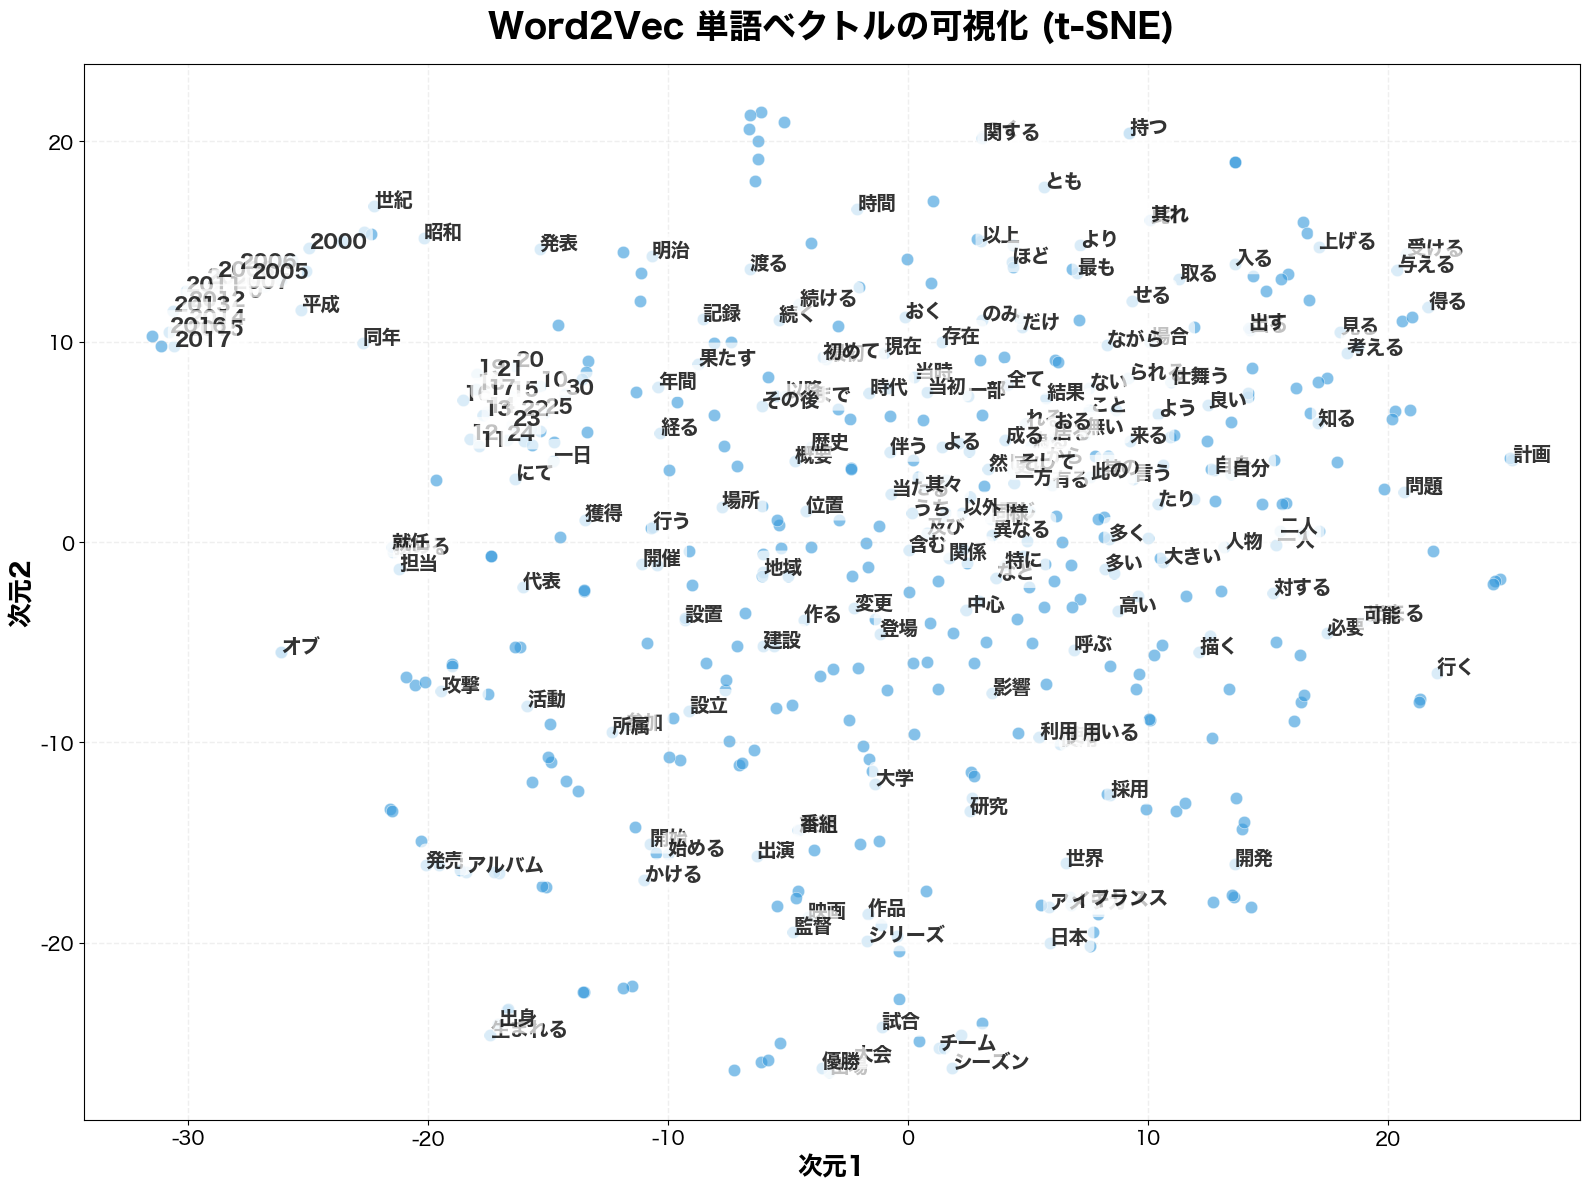

500語を可視化しました


In [26]:
# 単語ベクトルの可視化（t-SNE）

# 日本語フォント設定
plt.rcParams["font.sans-serif"] = [
    "Hiragino Sans",
    "Yu Gothic",
    "Meirio",
    "DejaVu Sans",
]
plt.rcParams["axes.unicode_minus"] = False

# 頻出上位500語を可視化
vocab_size = min(500, len(model.wv))
words = list(model.wv.index_to_key[:vocab_size])
word_vectors = np.array([model.wv[word] for word in words])

# t-SNEで2次元に圧縮
print("t-SNEで次元削減中...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_vectors_2d = tsne.fit_transform(word_vectors)

# プロット（スライド用に調整）
plt.figure(figsize=(16, 12), dpi=100)
plt.scatter(
    word_vectors_2d[:, 0],
    word_vectors_2d[:, 1],
    alpha=0.6,
    s=80,
    c="#3498db",
    edgecolors="white",
    linewidth=0.5,
)

# 一部の単語をラベル表示
for i in range(0, min(200, vocab_size), 1):
    plt.annotate(
        words[i],
        xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
        fontsize=14,
        fontweight="bold",
        alpha=0.8,
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", edgecolor="none", alpha=0.7
        ),
    )

plt.title(
    "Word2Vec 単語ベクトルの可視化 (t-SNE)", fontsize=24, fontweight="bold", pad=20
)
plt.xlabel("次元1", fontsize=18, fontweight="bold")
plt.ylabel("次元2", fontsize=18, fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.2, linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

print(f"{vocab_size}語を可視化しました")

## モデルの統計情報

In [27]:
# モデルの統計情報
print("=" * 80)
print("モデルの統計情報")
print("=" * 80)
print(f"語彙数: {len(model.wv):,}語")
print(f"ベクトル次元数: {model.wv.vector_size}")
print(f"ウィンドウサイズ: {model.window}")
print(f"最小出現回数: {model.min_count}")
print(f"学習アルゴリズム: {'Skip-gram' if model.sg else 'CBOW'}")
print(f"エポック数: {model.epochs}")

# 頻出単語トップ20
print("\n頻出単語トップ20:")
for i, word in enumerate(model.wv.index_to_key[:20], 1):
    print(f"{i:2d}. {word}")

モデルの統計情報
語彙数: 189,480語
ベクトル次元数: 300
ウィンドウサイズ: 5
最小出現回数: 5
学習アルゴリズム: CBOW
エポック数: 5

頻出単語トップ20:
 1. 為る
 2. れる
 3. 居る
 4. 有る
 5. から
 6. 成る
 7. こと
 8. よる
 9. 言う
10. など
11. 其の
12. 此の
13. ない
14. られる
15. 無い
16. よう
17. 行う
18. まで
19. 此れ
20. 日本
